## Imports

In [1]:
import numpy as np  # For numerical operations, especially handling arrays and probabilities

from tensorflow.keras.models import Sequential  # To build the CNN model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout  # For defining layers of the CNN
from tensorflow.keras.preprocessing.image import ImageDataGenerator  # For image data augmentation and preprocessing
from tensorflow.keras.callbacks import EarlyStopping  # For adding callbacks like early stopping during training

from sklearn.metrics import classification_report, confusion_matrix  # For evaluating the model's performance
import matplotlib.pyplot as plt  # For plotting graphs and visualizing data
import pandas as pd
import os

The dataset for Waste Categories of Recyclable and Organic is obtained from (https://www.kaggle.com/datasets/techsash/waste-classification-data/data)

The dataset for Waste Categories, specifically E Waste is obtained from
(https://www.kaggle.com/datasets/akshat103/e-waste-image-dataset/data)

The E Waste Dataset doesn't have that many images compared to Recyclable and Organic, therefore a technique called SMOTE (Synthetic Minority Over-sampling Technique) would be implemented to ensure a closer number of data for this class compared to the other class

## Files

In [2]:
train_dir = "./Waste/DATASET/TRAIN"
test_dir = "./Waste/DATASET/TEST"

In [3]:
# Create an ImageDataGenerator object for training data with augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Rescale the pixel values from [0, 255] to [0, 1]
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],  # Randomly adjust brightness
    fill_mode='nearest'  # Fill in new pixels after transformations
)

# Create an ImageDataGenerator object for testing data without augmentation
test_datagen = ImageDataGenerator(rescale=1./255)

# Load and iterate training dataset
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),  # Resize images to a uniform size
    batch_size=32,
    class_mode='categorical'  # Since you have more than two classes
)

# Load and iterate test dataset
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)

Found 24964 images belonging to 3 classes.
Found 2813 images belonging to 3 classes.


In [4]:
# Print the class indices to verify the classes
print(train_generator.class_indices)

# Get a batch of images and labels
images, labels = next(train_generator)

# Check the shapes
print(images.shape)  # Should be (batch_size, 150, 150, 3)
print(labels.shape)  # Should be (batch_size, 3) for 3 classes


{'E': 0, 'O': 1, 'R': 2}
(32, 150, 150, 3)
(32, 3)


Found 24964 images belonging to 3 classes.


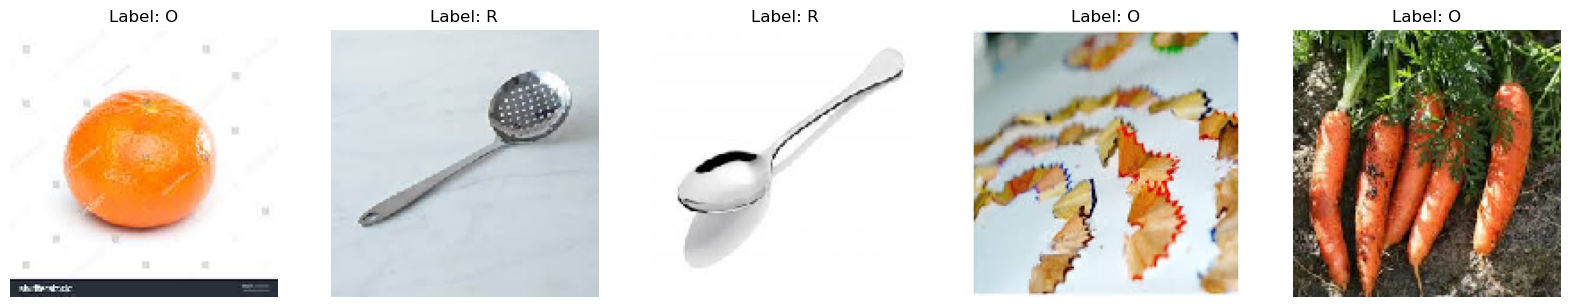

In [5]:
# Create an ImageDataGenerator object for loading the data
datagen = ImageDataGenerator(rescale=1./255)

# Load a batch of images
batch_size = 5  # Adjust this to the number of images you want to visualize
train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=batch_size,
    class_mode='categorical'
)

# Get a batch of images and labels
images, labels = next(train_generator)

# Map label indices to their corresponding class names
class_indices = train_generator.class_indices
class_labels = {v: k for k, v in class_indices.items()}

# Plot the images with their labels
plt.figure(figsize=(20, 5))
for i in range(batch_size):
    plt.subplot(1, batch_size, i + 1)
    plt.imshow(images[i])
    label_index = np.argmax(labels[i])  # Get the index of the class
    plt.title(f"Label: {class_labels[label_index]}")
    plt.axis('off')
plt.show()

In [6]:
def count_images_in_directory(directory):
    image_count = {}
    
    # Loop through each subdirectory in the main directory
    for subdir in os.listdir(directory):
        subdir_path = os.path.join(directory, subdir)
        
        # Check if the path is a directory
        if os.path.isdir(subdir_path):
            # Count the number of image files in the directory
            num_images = len([f for f in os.listdir(subdir_path) if os.path.isfile(os.path.join(subdir_path, f))])
            image_count[subdir] = num_images
    
    return image_count


In [7]:
train_image_count = count_images_in_directory(train_dir)
test_image_count = count_images_in_directory(test_dir)

print("Training Set Image Count:", train_image_count)
print("Test Set Image Count:", test_image_count)

Training Set Image Count: {'R': 9999, 'O': 12565, 'E': 2400}
Test Set Image Count: {'R': 1112, 'O': 1401, 'E': 300}


## Applying SMOTE

In [8]:
from imblearn.over_sampling import SMOTE
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model

In [9]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
model = Model(inputs=base_model.input, outputs=base_model.output)

In [10]:
train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    shuffle=False  
)

# Get the features from the convolutional base
features = model.predict(train_generator)
features_flattened = features.reshape(features.shape[0], -1)  # Flatten the features

# Get the labels
labels = train_generator.classes  # Labels corresponding to the images

Found 24964 images belonging to 3 classes.


2024-08-23 11:37:14.576898: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-08-23 11:37:14.610865: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


781/781 [==============================] - 2788s 4s/step


In [11]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

# Predict to get the test features
test_features = model.predict(test_generator)

# Flatten the features for input to the dense layers
test_features_flattened = test_features.reshape(test_features.shape[0], -1)

# Get the true labels for the test data
y_test = test_generator.classes


Found 2813 images belonging to 3 classes.


2024-08-23 12:23:43.814206: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


88/88 [==============================] - 344s 4s/step


In [12]:
smote = SMOTE()

# Apply SMOTE to the flattened features and the labels
X_resampled, y_resampled = smote.fit_resample(features_flattened, labels)

In [13]:
X_resampled, y_resampled = smote.fit_resample(features_flattened, labels)

# Check the shapes
print("Shape of X_resampled (features):", X_resampled.shape)
print("Shape of y_resampled (labels):", y_resampled.shape)


Shape of X_resampled (features): (37695, 8192)
Shape of y_resampled (labels): (37695,)


In [14]:
# Count the number of samples in each class
unique, counts = np.unique(y_resampled, return_counts=True)
class_distribution = dict(zip(unique, counts))

print("Class distribution after SMOTE:", class_distribution)

Class distribution after SMOTE: {0: 12565, 1: 12565, 2: 12565}


## Model for Training

In [15]:
class WasteClassificationModel:
    def __init__(self, input_shape=(150, 150, 3), num_classes=3):
        self.input_shape = input_shape
        self.num_classes = num_classes
        self.model = None

    def build_model(self):
        self.model = Sequential()
        self.model.add(Dense(512, activation='relu', input_shape=(8192,)))
        self.model.add(Dropout(0.5))
        self.model.add(Dense(256, activation='relu'))
        self.model.add(Dropout(0.5))
        self.model.add(Dense(128, activation='relu'))
        self.model.add(Dropout(0.5))
        self.model.add(Dense(self.num_classes, activation='softmax'))
        self.model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    def train_model(self, X_train, y_train, epochs=20, batch_size=32, validation_split=0.2):
        self.history = self.model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=validation_split)

    def evaluate_model(self, X_test, y_test):
        test_loss, test_acc = self.model.evaluate(X_test, y_test)
        print(f"Test Accuracy: {test_acc}")
        return test_loss, test_acc

    def predict(self, X):
        return self.model.predict(X)
    
    def print_classification_report(self, X_test, y_test, class_labels):
        y_pred = np.argmax(self.predict(X_test), axis=1)
        print(classification_report(y_test, y_pred, target_names=class_labels))
        print(confusion_matrix(y_test, y_pred))

In [16]:
waste_model = WasteClassificationModel()

# Build the model architecture
waste_model.build_model()

# Train the model using the SMOTE-resampled dataset
waste_model.train_model(X_resampled, y_resampled, epochs=20, batch_size=32, validation_split=0.2)

Epoch 1/20
943/943 [==============================] - 24s 25ms/step - loss: 0.5547 - accuracy: 0.7827 - val_loss: 0.2983 - val_accuracy: 0.8935
Epoch 2/20
943/943 [==============================] - 24s 25ms/step - loss: 0.3857 - accuracy: 0.8575 - val_loss: 0.2124 - val_accuracy: 0.9159
Epoch 3/20
943/943 [==============================] - 18s 19ms/step - loss: 0.3423 - accuracy: 0.8743 - val_loss: 0.1925 - val_accuracy: 0.9353
Epoch 4/20
943/943 [==============================] - 21s 22ms/step - loss: 0.3110 - accuracy: 0.8840 - val_loss: 0.1833 - val_accuracy: 0.9392
Epoch 5/20
943/943 [==============================] - 22s 24ms/step - loss: 0.2942 - accuracy: 0.8889 - val_loss: 0.1657 - val_accuracy: 0.9516
Epoch 6/20
943/943 [==============================] - 19s 20ms/step - loss: 0.2745 - accuracy: 0.8995 - val_loss: 0.1174 - val_accuracy: 0.9630
Epoch 7/20
943/943 [==============================] - 23s 25ms/step - loss: 0.2576 - accuracy: 0.9044 - val_loss: 0.1136 - val_accuracy:

In [17]:
waste_model.evaluate_model(test_features_flattened, y_test)

88/88 [==============================] - 0s 3ms/step - loss: 0.5764 - accuracy: 0.8468
Test Accuracy: 0.8467828035354614


(0.5763809084892273, 0.8467828035354614)

In [18]:
class_labels = ['E', 'O', 'R'] 
waste_model.print_classification_report(test_features_flattened, y_test, class_labels)

88/88 [==============================] - 0s 4ms/step
              precision    recall  f1-score   support

           E       0.78      0.84      0.81       300
           O       0.84      0.94      0.89      1401
           R       0.87      0.73      0.80      1112

    accuracy                           0.85      2813
   macro avg       0.83      0.84      0.83      2813
weighted avg       0.85      0.85      0.84      2813

[[ 252   10   38]
 [   4 1319   78]
 [  67  234  811]]


## Utilizing Model

In [19]:
from tensorflow.keras.preprocessing import image
import numpy as np

def preprocess_image(img_path, target_size=(150, 150)):
    # Load the image
    img = image.load_img(img_path, target_size=target_size)
    
    # Convert the image to an array
    img_array = image.img_to_array(img)
    
    # Rescale the pixel values to [0, 1]
    img_array = img_array / 255.0
    
    # Expand dimensions to match the input shape for the model
    img_array = np.expand_dims(img_array, axis=0)
    
    return img_array

In [20]:
def extract_features(img_array):
    # Use the VGG16 model to extract features
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
    model = Model(inputs=base_model.input, outputs=base_model.output)
    
    # Extract features
    features = model.predict(img_array)
    
    # Flatten the features
    features_flattened = features.reshape(features.shape[0], -1)
    
    return features_flattened


In [21]:
def classify_image(model, img_path):
    # Preprocess the image
    img_array = preprocess_image(img_path)
    
    # Extract features using VGG16
    features_flattened = extract_features(img_array)
    
    # Use the trained model to make a prediction
    prediction = model.predict(features_flattened)
    
    # Get the predicted class label
    predicted_class_index = np.argmax(prediction, axis=1)[0]
    
    return predicted_class_index

In [28]:
# Example of using the function to classify an image
class_labels = ['E-Waste', 'Organic', 'Recyclable']  # Update this with your actual class labels

# Path to the image you want to classify
img_path = "../WasteModel/Waste/Input/bottle.JPG"

# Classify the image
predicted_class_index = classify_image(waste_model.model, img_path)

# Get the predicted class label
predicted_class_label = class_labels[predicted_class_index]
print(f"The model predicts that the image is: {predicted_class_label}")

1/1 [==============================] - 0s 21ms/step
The model predicts that the image is: Recyclable


In [30]:
# Save the model
waste_model.model.save('waste_classification_model.h5')

### The model isn't too accurate, some things that can be improved

- Add Data Augmentation to adjust lighting because photos lighting are different
- Used pretrained model to train the data

## Data Augmentation Method 

Modified Above

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,               # Rescale pixel values from [0, 255] to [0, 1]
    rotation_range=30,            # Randomly rotate images by 0 to 30 degrees
    width_shift_range=0.2,        # Randomly shift images horizontally by 20% of the width
    height_shift_range=0.2,       # Randomly shift images vertically by 20% of the height
    shear_range=0.2,              # Randomly shear the images
    zoom_range=0.2,               # Randomly zoom in or out by 20%
    horizontal_flip=True,         # Randomly flip images horizontally
    brightness_range=[0.8, 1.2],  # Randomly adjust brightness
    fill_mode='nearest'           # Fill mode for new pixels
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),       # Resize images to a uniform size
    batch_size=32,
    class_mode='categorical'
)